In [70]:
# Solving Boltzmann Equations for Dark Matter Relic Abundance

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import kn

# Constants
G_N = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
c = 2.99792458e8   # Speed of light in m/s
hbar = 1.054571817e-34  # Reduced Planck constant in J⋅s
k_B = 1.380649e-23  # Boltzmann constant in J/K
M_Pl = np.sqrt(hbar * c / (8 * np.pi * G_N))  # Reduced Planck mass in kg
H_0 = 67.8*(1/3.086e19)
G_eV_2 = 6.7*1e-39
g_x = 2

# Convert to natural units (GeV)
M_Pl_GeV = M_Pl * c**2 / 1.602176634e-10

# Function to calculate g_*(T)
def g_star(T):
    # Convert input to numpy array if it's not already
    T = np.asarray(T)
    
    # Initialize output array with the same shape as input
    result = np.empty_like(T)
    
    # Apply conditions using numpy's where function
    result = np.where(T > 175, 106.75,
                      np.where(T > 200e-3, 80, 10.75))
    
    return result

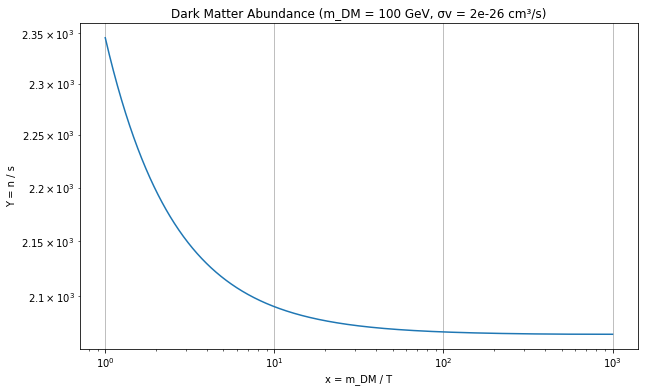

In [71]:
# Boltzmann equation
def boltzmann_eq_Y(Y, x, sigma_v, m_DM):
    # Y is n/s, x is m/T
    T = m_DM/x
    n_eq = ((m_DM**3) * kn(2, x)) / (2 * (np.pi**2) * x)  # Equilibrium number density
    s = (2 * (np.pi**2) / 45) * g_star(T) * (T**3)  # Entropy density
    H = np.sqrt((8 * (np.pi**3) * G_eV_2 * g_star(T)) / 90) * (T**2)  # Hubble parameter

    dYdx = (s*sigma_v/(H*x)) * ((n_eq/s)**2 - Y[0]**2)

    return dYdx

# Function to solve Boltzmann equation
def solve_boltzmann_Y(m_DM, sigma_v):
    x = np.logspace(0, 3, 1000)  # From x=1 to x=100
    n_eq_0 = ((m_DM**3) * kn(2, 1)) / (2 * (np.pi**2) * 1)
    s_0 = (2 * (np.pi**2) / 45) * g_star(1)
    Y_0 = n_eq_0/s_0  # Initial condition
    
    solution = odeint(boltzmann_eq_Y, Y_0, x, args=(sigma_v, m_DM))
    Y = solution.flatten()
    
    # Calculate Omega_DM
    rho_c = 3 * H_0**2 / (8 * np.pi * G_eV_2)  # Critical density
    s_0 = 2891.2  # Current entropy density in cm^-3
    Omega_DM = m_DM * Y[-1] * s_0 / rho_c
    
    return x, Y, Omega_DM

# Main calculation
m_DM = 100  # Dark matter mass in GeV
sigma_v = 2e-26  # Thermally averaged annihilation cross-section in cm^3/s

x, Y, Omega_DM = solve_boltzmann_Y(m_DM, sigma_v)

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(x, Y)
plt.xlabel('x = m_DM / T')
plt.ylabel('Y = n / s')
plt.title(f'Dark Matter Abundance (m_DM = {m_DM} GeV, σv = {sigma_v} cm³/s)')
plt.grid(True)
plt.show()


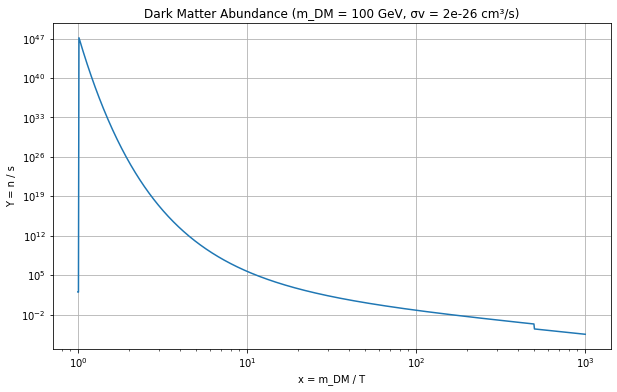

In [120]:
# Boltzmann equation
def boltzmann_eq_W(W, x, sigma_v, m_DM):
    # Y is n/s, x is m/T
    T = m_DM/x
    n_eq = (g_x * (m_DM**2) * T * kn(2, x)) / (2 * (np.pi**2))  # Equilibrium number density
    s = (2 * (np.pi**2) / 45) * g_star(T) * (T**3)  # Entropy density
    if n_eq == 0:
        W_eq = -np.inf
    else:
        W_eq = np.log(n_eq/s)

    lam = (2.76e35)*sigma_v*m_DM

    dWdx = (lam*np.sqrt(g_star(T))/(x**2)) * (np.exp(2*W_eq)*np.exp(-W[0]) - np.exp(W[0]))

    return dWdx

# Function to solve Boltzmann equation
def solve_boltzmann_W(x, m_DM, sigma_v, W_0):
    solution = odeint(boltzmann_eq_W, W_0, x, args=(sigma_v, m_DM))
    W = solution.flatten()
    
    # Calculate Omega_DM
    rho_c = 3 * H_0**2 / (8 * np.pi * G_eV_2)  # Critical density
    s_0 = 2891.2  # Current entropy density in cm^-3
    Omega_DM = m_DM * Y[-1] * s_0 / rho_c
    
    return x, W, Omega_DM

x = np.logspace(0, 3, 1000)  # From x=1 to x=100

n_eq = (g_x * (m_DM**2) * (m_DM/x) * kn(2, x)) / (2 * (np.pi**2))  # Equilibrium number density
n_eq_0 = (g_x * (m_DM**3) * kn(2, 1)) / (2 * (np.pi**2))
n_eq_approx = g_x * ((m_DM**2/(x*2*np.pi))**(3/2)) * np.exp(-x)  # Equilibrium number density
n_eq_0_approx = g_x * ((m_DM**2/(2*np.pi))**(3/2)) * np.exp(-1)  # Equilibrium number density
s = (2 * (np.pi**2) / 45) * g_star(m_DM/x) * ((m_DM/x)**3)  # Entropy density

s_0 = (2 * (np.pi**2) / 45) * g_star(m_DM) * (m_DM**3)
W_0 =  np.log(n_eq_0/s_0)  # Initial condition

# Main calculation
m_DM = 100  # Dark matter mass in GeV
sigma_v = (2e-26) # Thermally averaged annihilation cross-section in cm^3/s
x, W, Omega_DM = solve_boltzmann_W(x, m_DM, sigma_v, W_0)

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(x, m_DM*np.exp(W)*s/n_eq_0)
#plt.loglog(x, m_DM*(n_eq/n_eq_0))
#plt.loglog(x, m_DM*(n_eq_approx/n_eq_0_approx))
#plt.ylim(1e-20, 1e5)
plt.xlabel('x = m_DM / T')
plt.ylabel('Y = n / s')
plt.title(f'Dark Matter Abundance (m_DM = {m_DM} GeV, σv = {sigma_v} cm³/s)')
plt.grid(True)
plt.show()
